<center><h1>Rervoir Computing Networks</h1>
<h2><i>Time Series Analysis Assignment</i></h2></center>

*   **Manuel Andrés Hernández Alonso**, `mhernaal70.alumnes@ub.edu`, **niub**20274855



*Reservoir  computing  (RC)  is  a  family  of  Recurrent  Neural  Networks  models which achieved excellent performance in time series forecasting  and process modelling in the last few years. In machine learning, RC techniques  were  originally  introduced  under  the  name  Echo  State Networks (ESN).*

To begin, we'll retrieve the code from the RCN tutorial in the previous lectures.

In [41]:
import sys
import numpy as np
import network as Nt
import data as Data

#Retrieving arguments from the command line
def reservoir_exec(argv):
    test_name = str(argv[1])
    filter_name = str(argv[2])
    classifier = str(argv[3])
    num_nodes = int(argv[4])
    input_probability = np.float64(argv[5])
    reservoir_probability = np.float64(argv[6])

    d = Data.Data(80) #80% training 20% testing

    Network = Nt.Network()

    #Setting the right data for all the possible combinations of problems and classifiers

    if test_name == '5s':
        d.import_data('dataSorted_allOrientations.mat')
        if classifier == 'lin':
            d.build_train_labels_lin()
            d.build_test_labels_lin()
            
        elif classifier == 'log':
            d.build_train_labels_log()
            d.build_test_labels_log()

        else:
            print("This classifier is not supported for this test.")
            sys.exit(1)

        d.build_training_matrix()
        d.build_test_matrix()
        Network.L = 5

    elif test_name == 'lvr':
        if classifier == 'log' or classifier == '1nn':
            d.import_data('dataSorted_leftAndRight.mat')
            d.leftvsright_mixed()
            Network.L = 1

        else: 
            print("This classifier is not supported for this test.")
            sys.exit(1)

    else:
        print("This test does not exist.")
        sys.exit(1)

    #Filtering the data
    if filter_name not in d.spectral_bands.keys():
        print("The specified frequency band is not supported")
        sys.exit(1)

    d.training_data = d.filter_data(d.training_data,filter_name)
    d.test_data = d.filter_data(d.test_data,filter_name)


    #Computing the absolute value of the data, to get rid of negative numbers
    d.training_data = np.abs(d.training_data)
    d.test_data = np.abs(d.test_data)

    ########################
    # Define the network parameters
    ########################

    Network.T = d.training_data.shape[1] #Number of training time steps
    Network.n_min = 2540 #Number time steps dismissed
    Network.K = 128 #Input layer size
    Network.N = num_nodes #Reservoir layer size


    Network.u = d.training_data
    Network.y_teach = d.training_results

    Network.setup_network(d,num_nodes,input_probability,reservoir_probability,d.data.shape[-1])

    Network.train_network(d.data.shape[-1],classifier,d.num_columns, d.num_trials_train, d.train_labels, Network.N) 

    Network.mean_test_matrix = np.zeros([Network.N,d.num_trials_test,d.data.shape[-1]])

    Network.test_network(d.test_data, d.num_columns,d.num_trials_test, Network.N, d.data.shape[-1], t_autonom=d.test_data.shape[1])

    if classifier == 'lin':
        perf = d.accuracy_lin(Network.regressor.predict(Network.mean_test_matrix.T),d.test_labels)
        print(f'Performance for {test_name} using {classifier} : {perf}')

    elif classifier == 'log':
        perf = Network.regressor.score(Network.mean_test_matrix.T,d.test_labels.T)
        print(f'Performance for {test_name} using {classifier} : {perf}')

    elif classifier == '1nn':
        perf = Network.regressor.score(Network.mean_test_matrix.T,d.test_labels)
        print(f'Performance for {test_name} using {classifier} : {perf}')
    
    return perf, Network, d


In this code we can classify a Reservoir Computing Network with arguments to control which test to use, what classifier, and the parameters of the network. We will be testing the given dataset ```dataSorted_allOrientations.mat```.

### Five State Classification

In this section we will evaluate the Reservoir Computing Network on the Five State classification problem, where we will classify neural data that was collected during a reward retrieval task involving reaching and grasping.

In [2]:
# Units definition
units = [
    "baseline",
    "theta",
    "alpha",
    "beta",
    "lowgamma",
    "highgamma",
    "lowripple",
    "highripple",
    "lowmultiunit"
]

Firstly, we will be evaluating a base test with a Low Multi-unit frequency band, a linear regressor, 100 nodes for the RCN, and probabilities 0.5 and 0.2 for the input connection probabilities and reservoir connection probabilities.

In [38]:
argv = [
    None,
    "5s",
    "lowmultiunit",
    "lin",
    100,
    0.5,
    0.2    
        ]

In [42]:
perf, nt, d = reservoir_exec(argv)

Total of (128, 508, 140, 5)
Performance for 5s using lin : 0.9642857142857143


In [8]:
nt.mean_test_matrix.shape

(100, 140)

In [74]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
def display_graph(G, coeffs, clf="Linear", cl=0, figsize=(16,8)):
        importance = np.abs(coeffs)
        importance_normalized = (1+(importance-importance.min())/(importance.max()-importance.min()))*250
        edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())

        norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))
        cmap = plt.cm.viridis  # Colormap

        edge_colors = [cmap(norm(weight)) for weight in weights]

        min_size = 0.1
        max_size = 5
        edge_sizes = [min_size + (max_size - min_size) * norm(weight) for weight in weights]

        pos = nx.spring_layout(G, seed=42)  # Layout for visualization

        cmap2 = plt.cm.plasma  # Choose a colormap
        norm2 = mcolors.Normalize(vmin=importance.min(), vmax=importance.max())
        node_colors = cmap2(norm2(importance))

        plt.figure(figsize=figsize)
        nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=importance_normalized,
                edgelist=edges, edge_color=edge_colors, width=edge_sizes, arrowstyle='-|>', arrowsize=15,  font_color='white')


        # Adding colorbar for edge weights
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        # Create an axes for the colorbar
        cbar = plt.colorbar(sm, ax=plt.gca())
        cbar.set_label('Edge Weight')

        # Add a colorbar
        sm2 = plt.cm.ScalarMappable(cmap=cmap2, norm=norm2)
        sm2.set_array([])
        cbar2 = plt.colorbar(sm2, ax=plt.gca())
        cbar2.set_label('Node Importance')

        plt.title(f"Node and Weight importance of the reservoir layer for the {clf} classifier for class {cl}")
        plt.show()

Let's retrieve the network inside the RCN with the adjacency matrix stored in it. We can now consider the coefficients of the regressor layer as an importance metric of the nodes represented in the reservoir layer.

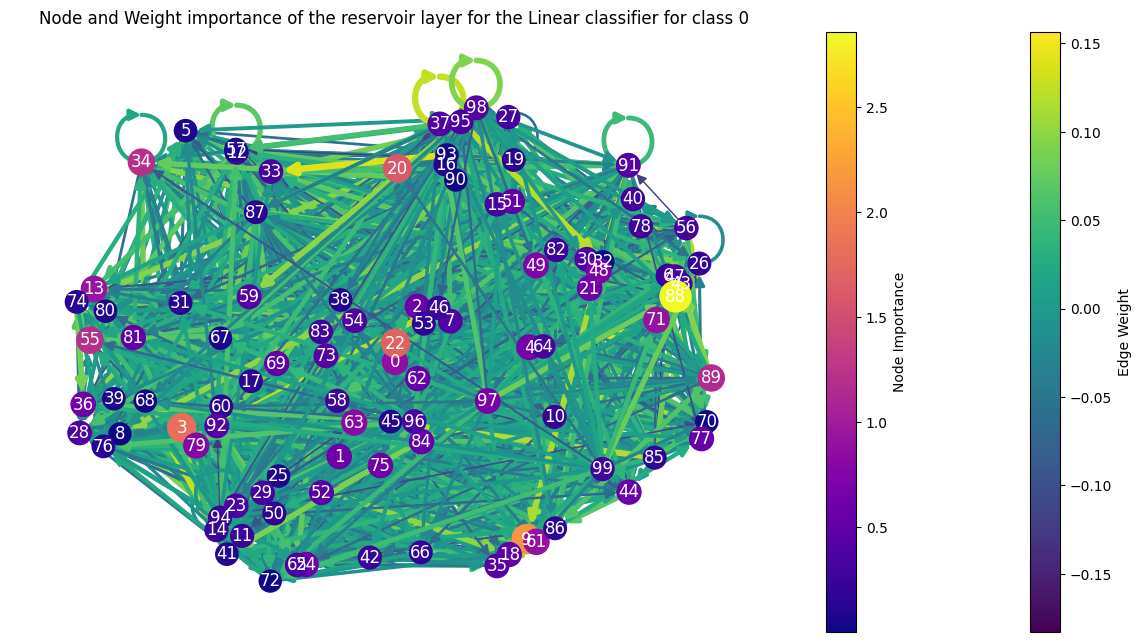

In [89]:
G = nx.convert_matrix.from_numpy_array(nt.W, create_using=nx.DiGraph)
coefficients = nt.regressor.coef_
display_graph(G, coefficients[0], "Linear", 0, (12,6))

We can see that there's a small number of nodes with high importance (they have the highest absolute values of the coefficients of the regressors). Then we can see the weights of the generated network. This is still just a rough visualization of a possible graph that can be generated in the reservoir network.

We can also check the importance of the nodes for the other classes. 

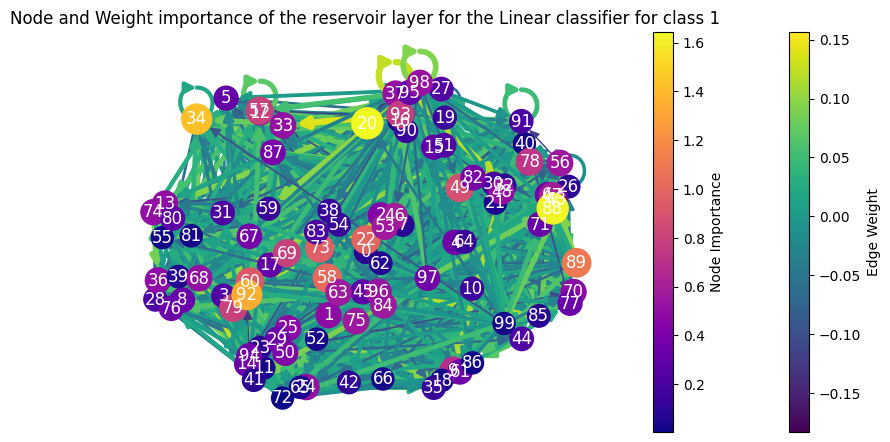

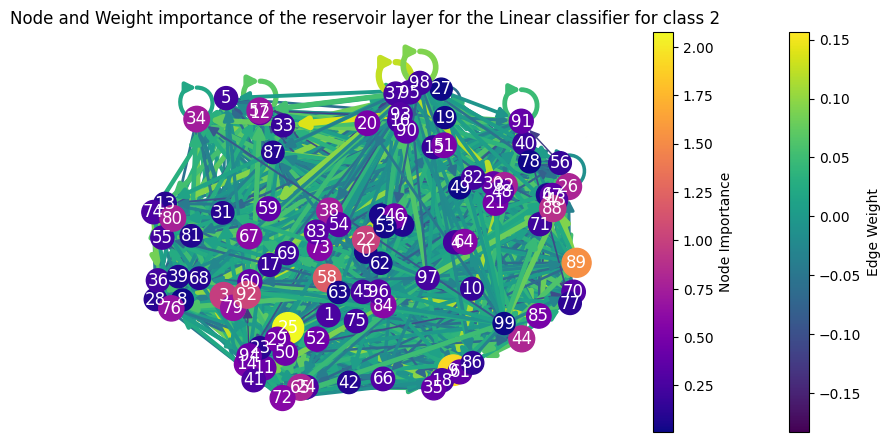

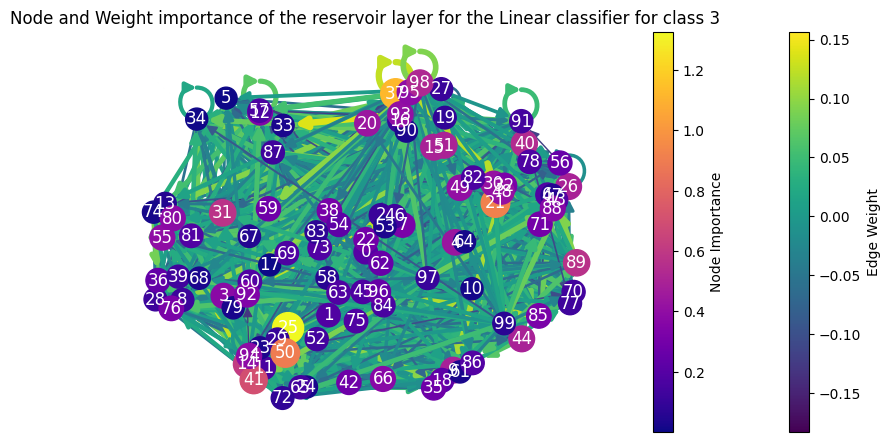

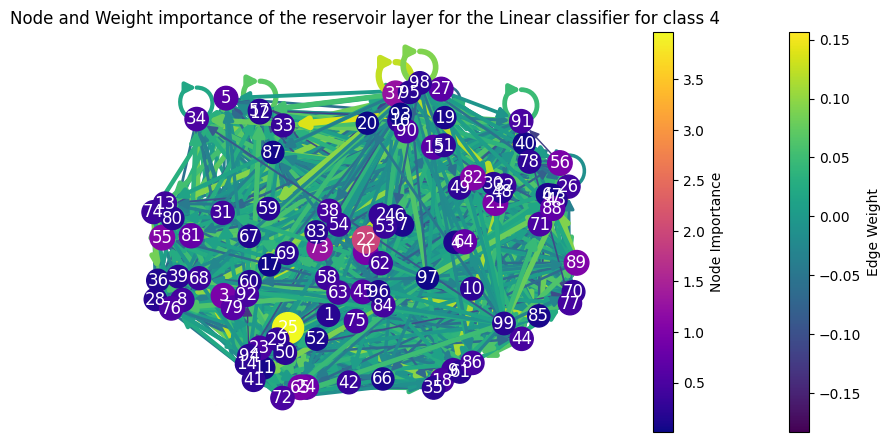

In [90]:
import networkx as nx
G = nx.convert_matrix.from_numpy_array(nt.W, create_using=nx.DiGraph)
coefficients = nt.regressor.coef_
for i in range(1,5):
    display_graph(G, coefficients[i], "Linear",i, (8,4))

As we can see, each class has its own set of important nodes for classification.

---

Now, let us check how important is the number of nodes when using the reservoir network. I trained both the linear and logistic classifier over all possible units and ranged the number of nodes between 10 and 100 included with steps of 10. This will allow us to see the effect of the number of nodes over the prediction accuracy.

In [4]:
performances = np.zeros((2, len(units), 10)) # classifier, units, state

In [ ]:
for ic, clf in enumerate(["lin", "log"]):
    for iu, unit in enumerate(units):
        for i_n, n in enumerate(range(10,101,10)):
            argv = [
                None,
                "5s",
                unit, # units
                clf, # classifier
                n, # number of nodes
                0.5,
                0.2    
                    ]
            try:
                perf, _, _ = reservoir_exec(argv)
                performances[ic, iu, i_n] = perf
            except:
                performances[ic, iu, i_n] = -1.0

In [7]:
performances.shape

(2, 9, 10)

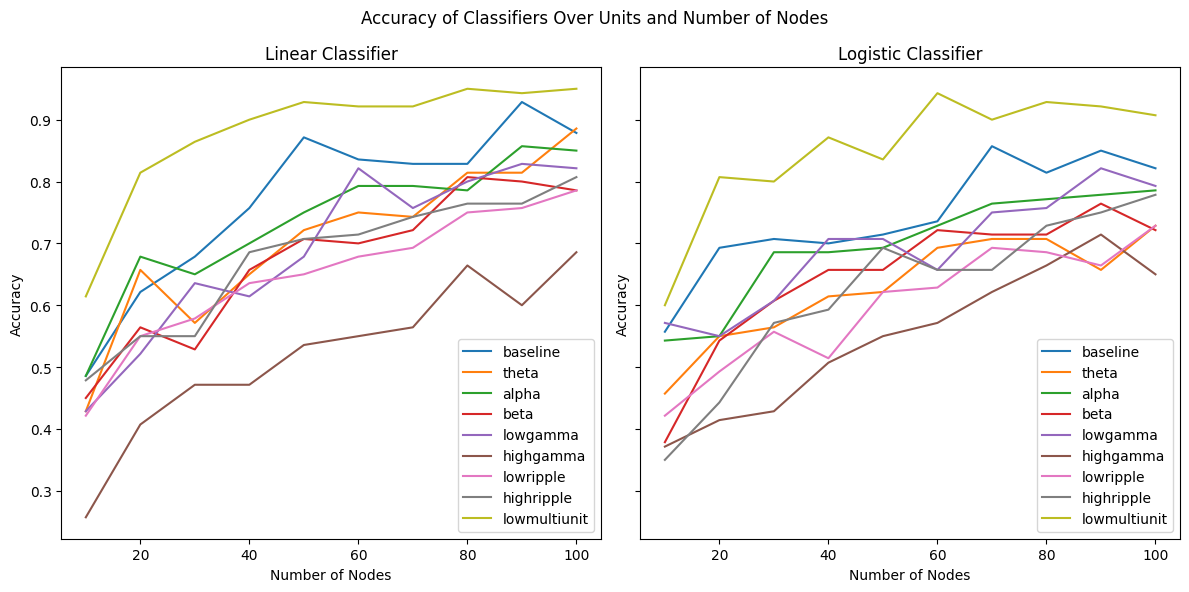

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Example data setup (replace this with your actual data)
num_classifiers = 2
num_units = 9
num_nodes = np.arange(10, 110, 10)
accuracies = performances  # Replace with your actual accuracy data

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Plot for each classifier
for i, cl in enumerate(["Linear", "Logistic"]):
    for j in range(num_units):
        axs[i].plot(num_nodes, accuracies[i, j], label=units[j])

    axs[i].set_title(f"{cl} Classifier")
    axs[i].set_xlabel("Number of Nodes")
    axs[i].set_ylabel("Accuracy")
    axs[i].legend()

plt.suptitle("Accuracy of Classifiers Over Units and Number of Nodes")
plt.tight_layout()
plt.show()

We can see that the accuracy ranges between 0.3 and 0.9 for all units combined, this means that there's enough variability when adjusting the number of nodes of the network. We can also see that in the frequency domain, the most important range and dimension is the Low multi-unit. And the next code cells also show that there might be diminishing returns after 100s of nodes.

In [15]:
argv = [None,"5s","lowmultiunit","lin",200,0.5,0.2]
perf, _, _ = reservoir_exec(argv)

Total of (128, 508, 140, 5)
Performance for 5s using lin : 0.9857142857142858


In [16]:
argv = [None,"5s","lowmultiunit","lin",500,0.5,0.2]
perf, _, _ = reservoir_exec(argv)

Total of (128, 508, 140, 5)
Performance for 5s using lin : 0.9928571428571429


In [19]:
argv = [None,"5s","lowmultiunit","lin",1000,0.5,0.2]
perf, _, _ = reservoir_exec(argv)

Total of (128, 508, 140, 5)
Performance for 5s using lin : 0.9928571428571429


In [17]:
argv = [None,"5s","lowmultiunit","log",200,0.5,0.2]
perf, _, _ = reservoir_exec(argv)

Total of (128, 508, 140, 5)
Performance for 5s using log : 0.95


In [18]:
argv = [None,"5s","lowmultiunit","log",500,0.5,0.2]
perf, _, _ = reservoir_exec(argv)

Total of (128, 508, 140, 5)
Performance for 5s using log : 0.9785714285714285


In [20]:
argv = [None,"5s","lowmultiunit","log",1000,0.5,0.2]
perf, _, _ = reservoir_exec(argv)

Total of (128, 508, 140, 5)
Performance for 5s using log : 0.9928571428571429


---

Finally, let's test the effect of the parameters relating to the probability of the connections. To simplify, I only used the low multi-unit and kept the linear classifier with 100 nodes.

In [ ]:
performances2 = np.zeros((10, 10)) # inprob, resprob

for i_n, in_prob in enumerate(np.arange(0.1, 1.01, 0.1)):
    for r_n, res_prob in enumerate(np.arange(0.1, 1.01, 0.1)):
        argv = [
            None,
            "5s",
            "lowmultiunit", # units
            "lin", # classifier
            100, # number of nodes
            in_prob, # input probability
            res_prob  # reservoir probability
                ]
        try:
            perf, _, _ = reservoir_exec(argv)
            performances2[i_n, r_n] = perf
        except:
            performances2[i_n, r_n] = -1.0

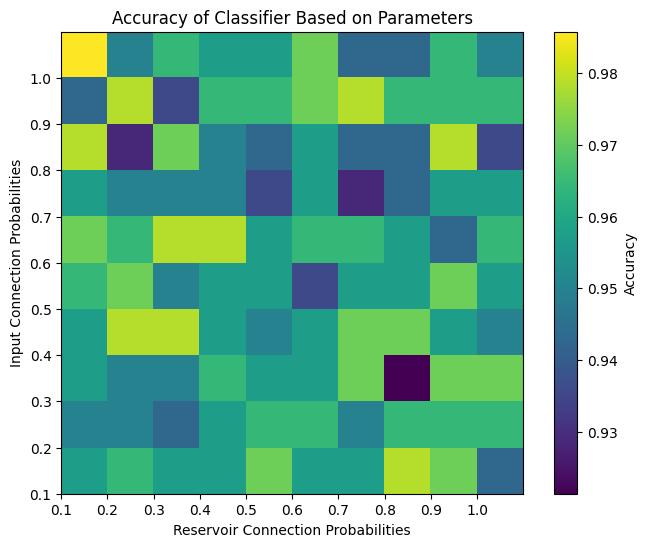

In [31]:
# Plotting heatmap
plt.figure(figsize=(8, 6))
im = plt.imshow(performances2, cmap='viridis', origin='lower', extent=[0.1, 1.1, 0.1, 1.1])

plt.title('Accuracy of Classifier Based on Parameters')
plt.xlabel('Reservoir Connection Probabilities')
plt.ylabel('Input Connection Probabilities')
plt.xticks(np.arange(0.1, 1.1, 0.1))
plt.yticks(np.arange(0.1, 1.1, 0.1))

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Accuracy')

plt.show()

As we can see from the heat map, there's not a significant parameter of probabilities related to prediction accuracy when fitting the model. This is probably due to the random nature of the network, more or less connections seem to have no evident effect on the network.

### Conclusion

Reservoir Computing Networks have proven to be a good solution for time series classification, leveraging a random graph to capture the random nature of graph respresentation of the given time series. The original network that is the source of the time series creates states inside the RCN iteratively to then be used in classification. We have seen that the main takeaway is that the most important parameter is the number of nodes of the network, as it's the part capable of learning states in the network. A secondary observation was the result of the random nature of the RCN, as the connection probabilities are just a random edge connection probability, they have little effect over the prediction accuracy.